## Mobilenet architecture for mobile devices

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
from datetime import datetime

!pip3 install torchviz
from torchviz import make_dot

     |████████████████████████████████| 51kB 2.3MB/s eta 0:00:011
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=3d56e783f30142855eedeedc3de4159bd87f9b040b4f02f39567f4afaeca492c
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


### 1) Depthwise Separable Convolution Block

In [10]:
class DepthSeperabelConv2d(nn.Module):
    """ Depthwise Separable Convolution """
    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super().__init__()
        self.depthwise = nn.Sequential(
            nn.Conv2d(
                input_channels,
                input_channels,
                kernel_size,
                groups=input_channels,
                **kwargs),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(inplace=True)
        )

        self.pointwise = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x


### 2) Basic Convolution Block

In [11]:
class BasicConv2d(nn.Module):
    """ Basic Conv Block """
    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(
            input_channels, output_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

## Architecture

In [30]:
class MobileNet(nn.Module):
    """
    Args:
        width multipler: The role of the width multiplier α is to thin
                         a network uniformly at each layer. For a given
                         layer and width multiplier α, the number of
                         input channels M becomes αM and the number of
                         output channels N becomes αN.
    """
    def __init__(self, width_multiplier=1, class_num=100):
       super().__init__()
       alpha = width_multiplier
       self.stem = nn.Sequential(
           BasicConv2d(3, int(32 * alpha), 3, padding=1, bias=False),
           DepthSeperabelConv2d(
               int(32 * alpha),
               int(64 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv1 = nn.Sequential(
           DepthSeperabelConv2d(
               int(64 * alpha),
               int(128 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(128 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv2 = nn.Sequential(
           DepthSeperabelConv2d(
               int(128 * alpha),
               int(256 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(256 * alpha),
               int(256 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv3 = nn.Sequential(
           DepthSeperabelConv2d(
               int(256 * alpha),
               int(512 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),

           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(512 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       #downsample
       self.conv4 = nn.Sequential(
           DepthSeperabelConv2d(
               int(512 * alpha),
               int(1024 * alpha),
               3,
               stride=2,
               padding=1,
               bias=False
           ),
           DepthSeperabelConv2d(
               int(1024 * alpha),
               int(1024 * alpha),
               3,
               padding=1,
               bias=False
           )
       )

       self.fc = nn.Linear(int(1024 * alpha), class_num)
       self.avg = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.avg(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probs = F.softmax(logits, dim=1)
        
        return logits, probs



In [31]:
net = MobileNet(width_multiplier=1, class_num=10)
print(net)

MobileNet(
  (stem): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): DepthSeperabelConv2d(
      (depthwise): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (pointwise): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (conv1): Sequential(
    (0): DepthSeperabelConv2d(
      (depthwise): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
  

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda


In [33]:
net = net.to(device)

In [34]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
       BasicConv2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]           2,112
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
DepthSeperabelConv2d-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 16, 16]             576
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 

## Data preparation

In [35]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [36]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False, 
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, 
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, 
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


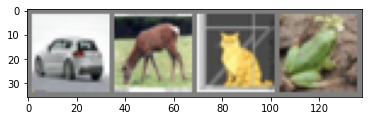

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

In [38]:
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
epochs = 20

In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay,  nesterov=True)

### Training

In [40]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [41]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [42]:

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [43]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    
    return model, optimizer, (train_losses, valid_losses)

In [44]:
model, optimizer, _ = training_loop(net, criterion, optimizer, train_loader, test_loader, epochs, device)

11:30:48 --- Epoch: 0	Train loss: 2.1792	Valid loss: 1.9670	Train accuracy: 25.09	Valid accuracy: 25.40
11:31:21 --- Epoch: 1	Train loss: 1.8228	Valid loss: 1.7096	Train accuracy: 34.09	Valid accuracy: 34.55
11:31:53 --- Epoch: 2	Train loss: 1.6636	Valid loss: 1.5809	Train accuracy: 40.74	Valid accuracy: 40.83
11:32:26 --- Epoch: 3	Train loss: 1.5403	Valid loss: 1.4895	Train accuracy: 45.17	Valid accuracy: 44.69
11:32:59 --- Epoch: 4	Train loss: 1.4454	Valid loss: 1.4242	Train accuracy: 49.08	Valid accuracy: 47.04
11:33:32 --- Epoch: 5	Train loss: 1.3702	Valid loss: 1.3415	Train accuracy: 52.43	Valid accuracy: 50.49
11:34:05 --- Epoch: 6	Train loss: 1.3040	Valid loss: 1.3019	Train accuracy: 55.28	Valid accuracy: 52.30
11:34:38 --- Epoch: 7	Train loss: 1.2375	Valid loss: 1.2614	Train accuracy: 57.94	Valid accuracy: 54.06
11:35:12 --- Epoch: 8	Train loss: 1.1789	Valid loss: 1.2154	Train accuracy: 60.72	Valid accuracy: 56.24
11:35:46 --- Epoch: 9	Train loss: 1.1164	Valid loss: 1.1818	Trai

### Pretrained Mobilenet